# Strong lensing forecast: Wierda et al. 2021

-  This notebook tries to reproduce the main forecasting results in the paper of Wierda et al, including the merger-event rate, time delay, redshift and Einstein radius distribution.
-  The pdf of magnification is also plotted for comparison.

## The observed lensed and unlensed event rates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json
from scipy.stats import gaussian_kde

from ler.rates import LeR

-  class initialization with paremeters and models in consistent with the paper.
-  the detector can be changed for different sensitivities.
-  the L/H/V sensitivity is taken as an example.

In [2]:
# initialize LeR
ler = LeR(
    npool=8,
    verbose=False,
    # SNR related
    sampling_frequency =  2048,
    waveform_approximant =  'IMRPhenomD',
    minimum_frequency =  20.0,
    snr_type =  'interpolation',
    ifos =  ['L1','H1','V1'],
    # GW related
    source_priors= {
        'merger_rate_density': 'merger_rate_density_bbh_popI_II_oguri2018', 
        'source_frame_masses': 'binary_masses_BBH_popI_II_powerlaw_gaussian', 
        'zs': 'sample_source_redshift', 
        'geocent_time': 'sampler_uniform', 
        'ra': 'sampler_uniform', 
        'dec': 'sampler_cosine', 
        'phase': 'sampler_uniform', 
        'psi': 'sampler_uniform', 
        'theta_jn': 'sampler_sine'
        },      
    source_priors_params= {
        'merger_rate_density': {'R0': 2.39e-08, 'b2': 1.6, 'b3': 2.1, 'b4': 30.}, 
        'source_frame_masses': {'mminbh': 4.59, 'mmaxbh': 86.22, 'alpha': 2.63, 'mu_g': 33.07, 'sigma_g': 5.69, 'lambda_peak': 0.10, 'delta_m': 4.82, 'beta': 1.26}, 
        'zs': None, 
        'geocent_time': {'min_': 1238166018, 'max_': 1269702018}, 
        'ra': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'dec': None, 
        'phase': {'min_': 0.0, 'max_': 6.283185307179586}, 
        'psi': {'min_': 0.0, 'max_': 3.141592653589793}, 
        'theta_jn': None
        },
    spin_zero= True,
    spin_precession= False,
    # lens related
    lens_type =  'epl_galaxy',
    lens_functions =  {
        'strong_lensing_condition': 'rjs_with_cross_section_SIS', 
        'optical_depth': 'optical_depth_SIS_haris', 
        'param_sampler_type': 'sample_all_routine',
        },
    lens_priors =  {
        'source_redshift_sl': 'strongly_lensed_source_redshifts', 
        'lens_redshift': 'lens_redshift_SDSS_catalogue', 
        'velocity_dispersion': 'velocity_dispersion_gengamma', 
        'axis_ratio': 'axis_ratio_rayleigh', 
        'axis_rotation_angle': 'axis_rotation_angle_uniform', 
        'shear': 'shear_norm', 
        'mass_density_spectral_index': 'mass_density_spectral_index_normal', 
        'source_parameters': 'sample_gw_parameters',
        },
    lens_priors_params =  {
        'source_redshift_sl': None, 
        'lens_redshift': None, 
        'velocity_dispersion': {'a':2.32 / 2.67, 'c':2.67}, 
        'axis_ratio': {'q_min': 0.2, 'q_max': 1.0}, 
        'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 2*np.pi}, 
        'shear': {'scale': 0.05}, 
        'mass_density_spectral_index': {'mean': 2.0, 'std': 0.2}, 'source_parameters': None
    },
    # image related
    n_min_images = 2,
    n_max_images = 4,
    lens_model_list =  ['EPL_NUMBA', 'SHEAR'],
)


2024-07-06 13:23:07.747802: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 13:23:07.871297: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 13:23:08.727774: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 13:23:08.733592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-06 13:23:10.723804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

-  sample unlensed parameters.

In [3]:
ler.batch_size = 200000
unlensed_param = ler.unlensed_cbc_statistics(size=1000000, resume=True, save_batch=False,output_jsonfile='unlensed_cbc_bbh.json')

unlensed params will be store in ./ler_data/unlensed_cbc_bbh.json
chosen batch size = 200000 with total size = 1000000
There will be 5 batche(s)
resuming from ./ler_data/unlensed_cbc_bbh.json
saving all unlensed_params in ./ler_data/unlensed_cbc_bbh.json...


- sample lensed parameters.

In [4]:
ler.batch_size = 200000
lensed_param = ler.lensed_cbc_statistics(size=1000000, resume=True, save_batch=False, output_jsonfile='lensed_cbc_bbh2.json')

lensed params will be store in ./ler_data/lensed_cbc_bbh2.json
chosen batch size = 200000 with total size = 1000000
There will be 5 batche(s)
resuming from ./ler_data/lensed_cbc_bbh2.json
saving all lensed_params in ./ler_data/lensed_cbc_bbh2.json...


- calculate the detectable lensed and unlensed annual merger rate.

In [5]:
_, unlensed_param_detectable = ler.unlensed_rate();
_, lensed_param_detectable = ler.lensed_rate();

getting unlensed_params from json file ./ler_data/unlensed_cbc_bbh.json...
given detectability_condition == 'step_function'
total unlensed rate (yr^-1) (with step function): 1054.1066703892322
number of simulated unlensed detectable events: 17310
number of all simulated unlensed events: 1700000
storing detectable unlensed params in ./ler_data/unlensed_param_detectable.json
getting lensed_params from json file ./ler_data/lensed_cbc_bbh2.json...
given detectability_condition == 'step_function'
total lensed rate (yr^-1) (with step function): 0.7425037351989888
number of simulated lensed detectable events: 8815
number of simulated all lensed events: 1200000
storing detectable lensed params in ./ler_data/lensed_param_detectable.json


-  calculate the rate ratio.

In [6]:
ler.rate_ratio();
# rate_ratio, unlensed_param_detectable, lensed_param_detectable = ler.rate_comparision_with_rate_calculation()

unlensed_rate: 1054.1066703892322
lensed_rate: 0.7425037351989888
ratio: 1419.6651416261693


-  get parameters from lensed data.

In [7]:
lensed_param_detectable = get_param_from_json('./ler_data/lensed_param_detectable.json')
snr = lensed_param_detectable['optimal_snr_net']

-  set the SNR threshold to be 8.
-  calculate the ratio of double, triple and quadruple images.

In [8]:
# ratio of double, triple and quadruple images
idx1 = abs(snr)>8
idx2 = np.sum(idx1, axis=1)
ratio_double = np.sum(idx2==2)/len(idx2)
ratio_triple = np.sum(idx2==3)/len(idx2)
ratio_quadruple = np.sum(idx2==4)/len(idx2)
print(ratio_double)
print(ratio_triple)
print(ratio_quadruple)

0.7032331253545093
0.19965967101531482
0.09710720363017583


## Time delay distribution for observed images.

In [9]:
# time delay

time_delay = lensed_param_detectable['time_delays']

### Double images.

-  extract time delay for double-image events.
- calculate the time difference between the two images.

In [10]:
# 2 images
idx_row_double = np.array(idx2 == 2)
idx1_double =idx1[idx_row_double]

t_delay_double = (time_delay[idx_row_double][idx1_double]).reshape(-1,2)

dt12_dou = abs(t_delay_double[:,1]-t_delay_double[:,0])/ (24*3600)
dt12_dou = dt12_dou[~np.isnan(dt12_dou)]
log_t12_dou = np.log10(dt12_dou)

-  make a KDE plot for the time-delay distribution.

In [11]:
# KDE plot
from sklearn.neighbors import KernelDensity

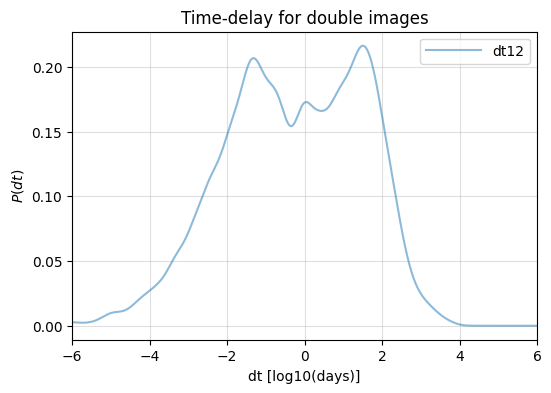

In [12]:
# plot
plt.figure(figsize=(6,4))
dt_log = np.linspace(-6, 6, 1000)

kde_log_t12_dou = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t12_dou).reshape(-1,1))
plt.plot(dt_log, np.exp(kde_log_t12_dou.score_samples(dt_log.reshape(-1,1))), label='dt12', color='C0', linestyle='-', alpha=0.5)

plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time-delay for double images')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-6, 6)
plt.show()

-  different from the paper, there are two peaks in the plot.

-  triple and quadruple images cases are of the similar trick.

### Triple images.

In [13]:
# 3 images
idx_row_triple = np.array(idx2 == 3)
idx1_triple =idx1[idx_row_triple]

t_delay_triple = (time_delay[idx_row_triple][idx1_triple]).reshape(-1,3)

-  calculate the time difference for neighbouring events.

In [14]:
dt12_tri = abs(t_delay_triple[:,1]-t_delay_triple[:,0])/ (24*3600)
dt23_tri = abs(t_delay_triple[:,2]-t_delay_triple[:,1])/ (24*3600)

dt12_tri = dt12_tri[~np.isnan(dt12_tri)]
dt23_tri = dt23_tri[~np.isnan(dt23_tri)]

log_t12_tri = np.log10(dt12_tri)
log_t23_tri = np.log10(dt23_tri)

-  plot the time-delay distributions for neighbouring events and the sum.

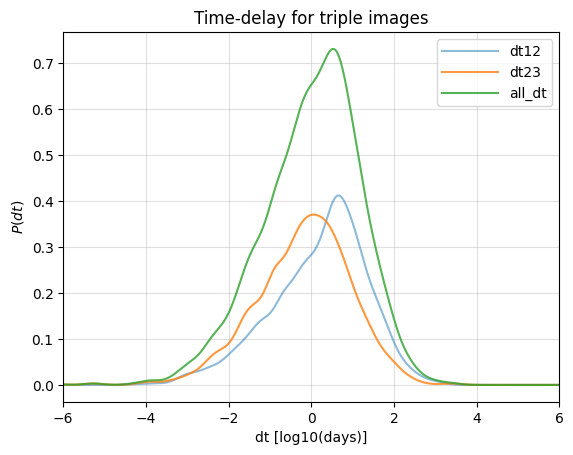

In [15]:
# triple images
kde_log_t12_tri = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t12_tri).reshape(-1,1))
kde_log_t23_tri = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t23_tri).reshape(-1,1))

plt.plot(dt_log, np.exp(kde_log_t12_tri.score_samples(dt_log.reshape(-1,1))), label='dt12', color='C0', linestyle='-', alpha=0.5)
plt.plot(dt_log, np.exp(kde_log_t23_tri.score_samples(dt_log.reshape(-1,1))), label='dt23', color='C1', linestyle='-', alpha=0.8)
plt.plot(dt_log, np.exp(kde_log_t12_tri.score_samples(dt_log.reshape(-1,1)))+np.exp(kde_log_t23_tri.score_samples(dt_log.reshape(-1,1))), label='all_dt', color='C2', linestyle='-', alpha=0.8)

plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time-delay for triple images')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-6, 6)
plt.show()

### Quadruple images.

In [16]:
# 4 images
idx_row_quadruple = np.array(idx2 == 4)
idx1_quadruple =idx1[idx_row_quadruple]

t_delay_quadruple = (time_delay[idx_row_quadruple][idx1_quadruple]).reshape(-1,4)

In [17]:
dt12_qua = abs(t_delay_quadruple[:,1]-t_delay_quadruple[:,0])/ (24*3600)
dt23_qua = abs(t_delay_quadruple[:,2]-t_delay_quadruple[:,1])/ (24*3600)
dt34_qua = abs(t_delay_quadruple[:,3]-t_delay_quadruple[:,2])/ (24*3600)

dt12_qua = dt12_qua[~np.isnan(dt12_qua)]
dt23_qua = dt23_qua[~np.isnan(dt23_qua)]
dt34_qua = dt34_qua[~np.isnan(dt34_qua)]

log_t12_qua = np.log10(dt12_qua)
log_t23_qua = np.log10(dt23_qua)
log_t34_qua = np.log10(dt34_qua)

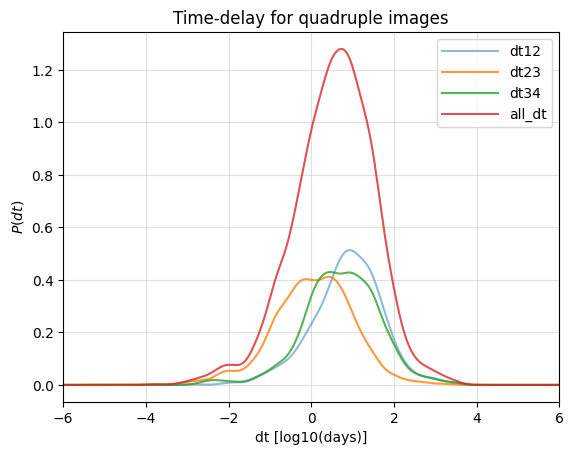

In [18]:
# quadruple images
kde_log_t12_qua = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t12_qua).reshape(-1,1))
kde_log_t23_qua = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t23_qua).reshape(-1,1))
kde_log_t34_qua = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(np.array(log_t34_qua).reshape(-1,1))

plt.plot(dt_log, np.exp(kde_log_t12_qua.score_samples(dt_log.reshape(-1,1))), label='dt12', color='C0', linestyle='-', alpha=0.5)
plt.plot(dt_log, np.exp(kde_log_t23_qua.score_samples(dt_log.reshape(-1,1))), label='dt23', color='C1', linestyle='-', alpha=0.8)
plt.plot(dt_log, np.exp(kde_log_t34_qua.score_samples(dt_log.reshape(-1,1))), label='dt34', color='C2', linestyle='-', alpha=0.8)
plt.plot(dt_log, np.exp(kde_log_t12_qua.score_samples(dt_log.reshape(-1,1)))+np.exp(kde_log_t23_qua.score_samples(dt_log.reshape(-1,1)))+np.exp(kde_log_t34_qua.score_samples(dt_log.reshape(-1,1))), label='all_dt', color='C3', linestyle='-', alpha=0.8)

plt.xlabel(r'dt [log10(days)]')
plt.ylabel(r'$P(dt)$')
plt.title('Time-delay for quadruple images')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-6, 6)
plt.show()

# Einstein radii distribution.

-  get the distributions for Einstein radii of detected lensed events.

In [19]:
lensed_param = get_param_from_json("/home/lisali/surip/ler_data/lensed_param_detectable.json")
theta_E_det = lensed_param["theta_E"]

-  sample the prior distribution of zs, zl and sigma.
-  sample the prior distribution of Einstein radii.

In [20]:
zs_prior = ler.sample_source_redshift(size=100000)
zl_prior = ler.sample_lens_redshift(zs=zs_prior)
sigma_prior = ler.sample_velocity_dispersion(len(zs_prior))

In [21]:
theta_E_prior = ler.compute_einstein_radii(sigma_prior,zl_prior, zs_prior)

-  plot the histogram and KDE for Einstein radii of detected lensed events and the underlying population.

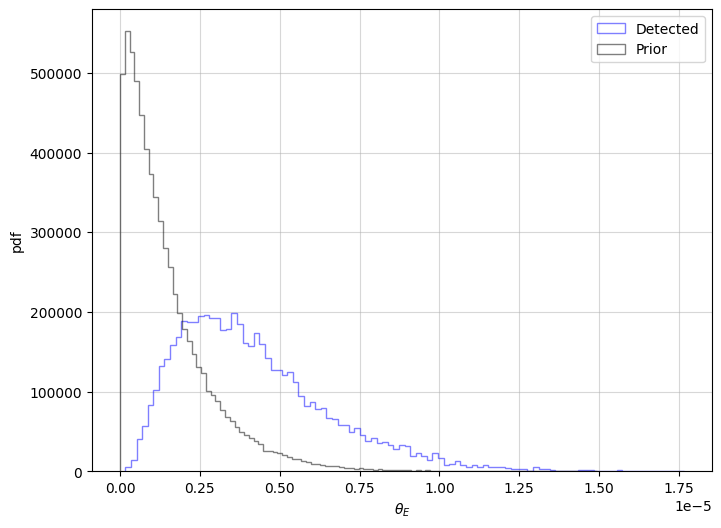

In [36]:
# plt hist
plt.figure(figsize=(8, 6))
plt.hist(theta_E_det, bins=100, alpha=0.5, label='Detected', color='blue', density=True, histtype='step')
plt.hist(theta_E_prior, bins=100, alpha=0.5, label='Prior', color='black', density=True, histtype='step')
plt.xlabel(r'$\theta_E$')
plt.ylabel('pdf')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

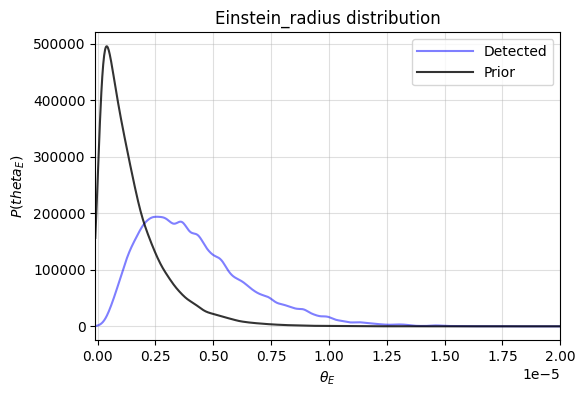

In [23]:
# KDE
from sklearn.neighbors import KernelDensity

kde_theta_E_prior = KernelDensity(kernel='gaussian', bandwidth=2e-7).fit(np.array(theta_E_prior).reshape(-1,1))
kde_theta_E_det = KernelDensity(kernel='gaussian', bandwidth=2e-7).fit(np.array(theta_E_det).reshape(-1,1))

# plot
plt.figure(figsize=(6,4))
d_theta_E = np.linspace(-1e-7, 2e-5, 1000)
plt.plot(d_theta_E, np.exp(kde_theta_E_det.score_samples(d_theta_E.reshape(-1,1))), label='Detected', color='blue', linestyle='-', alpha=0.5)
plt.plot(d_theta_E, np.exp(kde_theta_E_prior.score_samples(d_theta_E.reshape(-1,1))), label='Prior', color='black', linestyle='-', alpha=0.8)

plt.xlabel(r'$\theta_E$')
plt.ylabel(r'$P(theta_E)$')
plt.title('Einstein_radius distribution')
leg = plt.legend(handlelength=4)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(-1e-7, 2e-5)
#plt.savefig("redshift_distribution_bns.png")
plt.show()

# Magnification.

-  magnifications for double, triple and quadruple images are selected respectively
- histograms are plotted for each case.

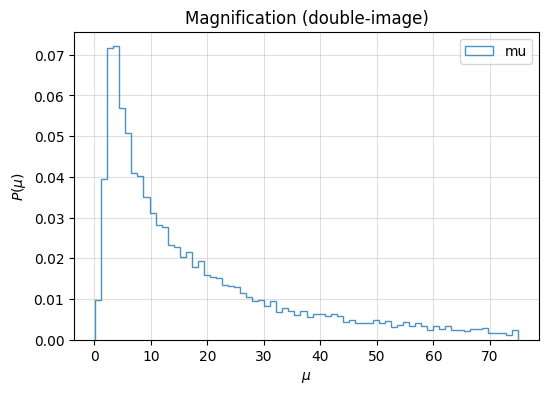

In [26]:
# magnification for double_lensed condition
mu = lensed_param_detectable['magnifications']
mu_double_row = mu[idx_row_double]
mu_double = abs(mu_double_row[idx1_double])

# plot hist
mu_double_ = []
for i in mu_double:
    if i > -75 and i < 75:
        mu_double_.append(i)

plt.figure(figsize=(6, 4))
plt.hist(mu_double_, bins=70, alpha=0.8, label='mu', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$P(\mu)$')
plt.title('Magnification (double-image)')
plt.show()

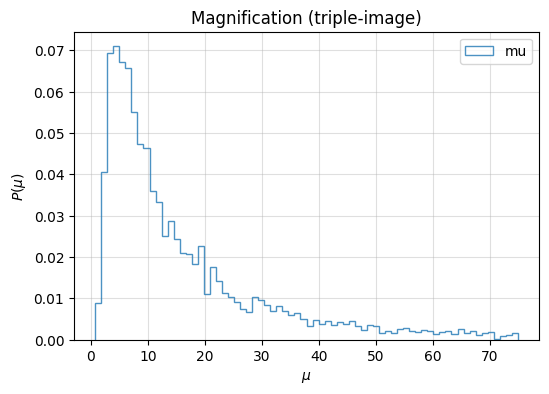

In [27]:
# magnification for triple_lensed condition
mu = lensed_param_detectable['magnifications']
mu_triple_row = mu[idx_row_triple]
mu_triple = abs(mu_triple_row[idx1_triple])

# plot hist
mu_triple_ = []
for i in mu_triple:
    if i > -75 and i < 75:
        mu_triple_.append(i)

plt.figure(figsize=(6, 4))
plt.hist(mu_triple_, bins=70, alpha=0.8, label='mu', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$P(\mu)$')
plt.title('Magnification (triple-image)')
plt.show()

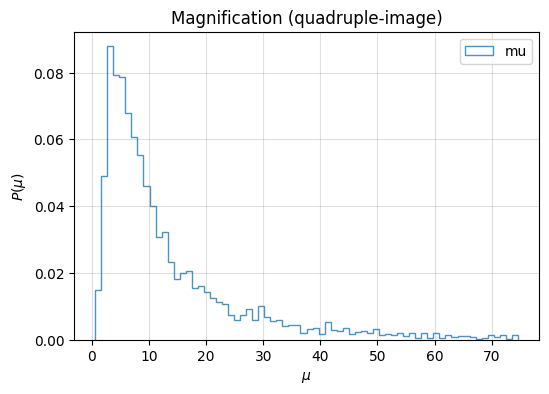

In [28]:
# magnification for quadruple_lensed condition
mu = lensed_param_detectable['magnifications']
mu_quadruple_row = mu[idx_row_quadruple]
mu_quadruple = abs(mu_quadruple_row[idx1_quadruple])

# plot hist
mu_quadruple_ = []
for i in mu_quadruple:
    if i > -75 and i < 75:
        mu_quadruple_.append(i)

plt.figure(figsize=(6, 4))
plt.hist(mu_quadruple_, bins=70, alpha=0.8, label='mu', density=True, histtype='step')
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$P(\mu)$')
plt.title('Magnification (quadruple-image)')
plt.show()

# Redshift distribution.

In [40]:
unlensed_param_det = get_param_from_json("./ler_data/unlensed_param_detectable.json")
lensed_param_det = get_param_from_json('./ler_data/lensed_param_detectable.json')

-  get redshift distributions for observed unlensed, lensed and quadruply lensed sources.

In [45]:
# source redshift
zs_unlensed_det = unlensed_param_det["zs"]
zs_lensed_det = lensed_param_det["zs"]

# quadruple images
qua_zs_lensed_det = lensed_param_det['zs'][idx_row_quadruple]

-  sample prior lens redshift distribution.
-  get redshift distributions for quadruple lenses.

In [49]:
# lens redshift
zl_prior = ler.sample_lens_redshift(zs=zs_prior)

# quadtuple lenses
qua_zl_lensed = lensed_param_det['zl'][idx_row_quadruple]

In [50]:
from sklearn.neighbors import KernelDensity

kde_zs_unlensed = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(zs_unlensed_det).reshape(-1,1))
kde_zs_lensed = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(zs_lensed_det).reshape(-1,1))
kde_qua_zs_lensed = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(qua_zs_lensed_det).reshape(-1,1))

kde_zl_unlensed = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(zl_prior).reshape(-1,1))
kde_qua_zl_lensed = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(np.array(qua_zl_lensed).reshape(-1,1))

-  plot a KDE for redshift distribution. A larger sample size wiil make the plot more regular and smooth.

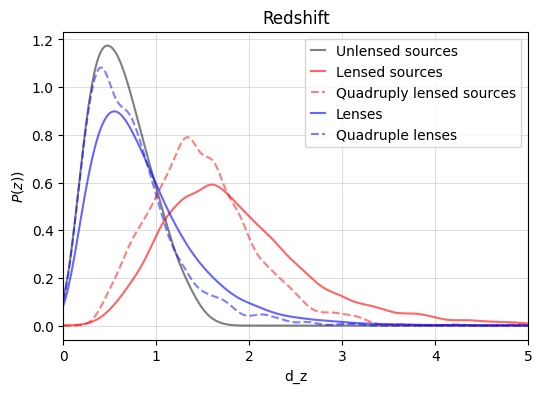

In [51]:
# plot
plt.figure(figsize=(6,4))
d_z = np.linspace(0, 5, 1000)
plt.plot(d_z, np.exp(kde_zs_unlensed.score_samples(d_z.reshape(-1,1))), label='Unlensed sources', color='black', linestyle='-', alpha=0.5)
plt.plot(d_z, np.exp(kde_zs_lensed.score_samples(d_z.reshape(-1,1))), label='Lensed sources', color='red', linestyle='-', alpha=0.6)
plt.plot(d_z, np.exp(kde_qua_zs_lensed.score_samples(d_z.reshape(-1,1))), label='Quadruply lensed sources', color='red', linestyle='--', alpha=0.5)

plt.plot(d_z, np.exp(kde_zl_unlensed.score_samples(d_z.reshape(-1,1))), label='Lenses', color='blue', linestyle='-', alpha=0.6)
plt.plot(d_z, np.exp(kde_qua_zl_lensed.score_samples(d_z.reshape(-1,1))), label='Quadruple lenses', color='blue', linestyle='--', alpha=0.5)

plt.xlabel(r'd_z')
plt.ylabel(r'$P(z))$')
plt.title('Redshift')
leg = plt.legend(handlelength=1)
for line in leg.get_lines():
    line.set_linewidth(1.5)
plt.grid(alpha=0.4)
plt.xlim(0, 5)
plt.show()